<a href="https://colab.research.google.com/github/benkrikler/wavefilter/blob/main/notebooks/train_simple_pulse_finder_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y wavefilter
!pip install "git+https://github.com/benkrikler/wavefilter@BK_debug-plotting#egg=wavefilter"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/benkrikler/wavefilter (to revision BK_debug-plotting) to /tmp/pip-install-201pjv_a/wavefilter_e02d5714439c48cc877c30d98ff850da
  Running command git clone -q https://github.com/benkrikler/wavefilter /tmp/pip-install-201pjv_a/wavefilter_e02d5714439c48cc877c30d98ff850da
  Running command git checkout -b BK_debug-plotting --track origin/BK_debug-plotting
  Switched to a new branch 'BK_debug-plotting'
  Branch 'BK_debug-plotting' set up to track remote branch 'BK_debug-plotting' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.2 MB 11.6 MB/s 
     |████████████████████████████████| 965 kB 61.9 MB/s 
  Created wheel for wavefilter: filename=wavefilter-0.0.1-py3-none-any.whl size=10431 sha256=5d42555d189433a4c4439b9d4f60f9c7e135ae9ea

In [2]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4149 sha256=0f6931e03c9c1440c1b54c5beee4fb5a1ee23104b50ec4fdbae6a00aec5ebd86
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [1]:
import numpy as np
import pandas as pd
import logging
import torch
from torch import nn
import torch.nn.functional as F
import wavefilter
import wavefilter.datasets as wds
import wavefilter.pulse_functions as wps
import wavefilter.models as models
from wavefilter.evaluate import split_parameters, train_parallel_pulse_finder
from wavefilter.inspect import InspectActivations
import matplotlib.pyplot as plt
from torchviz import make_dot, make_dot_from_trace

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
wavefilter.evaluate.logging.basicConfig(level=logging.INFO)

Using cuda device


In [2]:
# from importlib import reload
# reload(wavefilter.inspect)
# reload(wavefilter)

## Make some data

In [3]:
n_samples = 5000 if device == "cpu" else 10000
data, truth = wds.generate_double_pulse_dataset(n_samples, in_noise=0.05, out_noise=2, shape=40, dt2_low=150, dt2_high=700)
# Add an extra dimension for the channel number
data

array([[-0.0488556 ,  3.0203648 ,  0.49799305, ...,  0.42965588,
         1.911409  , -0.24540009],
       [ 0.9487511 ,  2.1307724 , -3.1975896 , ..., -1.1144282 ,
         0.29541633,  1.1595147 ],
       [-0.96117604, -1.2735624 , -1.6840193 , ..., -1.5973573 ,
        -0.34974688,  0.60112673],
       ...,
       [ 0.22339457,  0.98759097, -0.4411283 , ...,  0.21596257,
        -0.9495757 ,  0.39897305],
       [ 0.36059234,  0.9130097 ,  0.98915756, ..., -0.7651045 ,
         3.1663656 ,  0.8172103 ],
       [ 0.98225945, -2.552006  , -0.60376626, ..., -0.22070928,
         3.0493321 , -2.0909765 ]], dtype=float32)

In [4]:
ds = wds.to_torch_dataset(data)
train_loader = torch.utils.data.DataLoader(ds, batch_size=100, shuffle=False)
for i, d in enumerate(train_loader):
  print(f"i={i}")
  print([(dd.shape, dd.mean) for dd in d])
  if i > 2: 
    break

i=0
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f79f7892650>)]
i=1
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f7a7a585650>)]
i=2
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f79f78965f0>)]
i=3
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f79f78985f0>)]


## Set up the model

In [5]:
class Conv1dPulseFinderAttention_v4(models.Conv1dPulseFinderAttentionBase):
    def forward(self, ampl: torch.Tensor, original: torch.Tensor):
        inputs = super().forward_step1(ampl, original)
        inputs = torch.roll(inputs, self.pf_length //2, -1)
       # scale = self.scale(inputs)
       # attend = torch.tanh(F.softshrink(scale))
       # return F.softmax(attend, -1)
        attend = F.leaky_relu(inputs)
        attend = self.scale(attend)
        attend = torch.sigmoid(attend)
        #attend = F.leaky_relu(inputs)
        attend = F.softmax(attend, -1)
        inputs = torch.roll(inputs, self.pf_length //2, -1)
        return attend

attention = models.ParallelWeightedModules()
attention.add("conv_pulse_finder", Conv1dPulseFinderAttention_v4(50, False), 0)
attention.add("soft_max", models.GlobalSoftMaxAttention(), 1)

model = models.WaveFilter(200, attention).to(device)
#model = models.WaveFilter(200, models.GlobalSoftMaxAttention()).to(device)
print(model)

WaveFilter(
  (convolve): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  (attend): ParallelWeightedModules(
    module_weights=(conv_pulse_finder=0,soft_max=1)
    (conv_pulse_finder): Conv1dPulseFinderAttention_v4(
      (pulse_finder): Conv1d(1, 1, kernel_size=(50,), stride=(1,), padding=same)
      (combine): Conv1d(2, 1, kernel_size=(5,), stride=(1,), padding=same)
      (scale): Conv1d(1, 1, kernel_size=(1,), stride=(1,), padding=same)
    )
    (soft_max): GlobalSoftMaxAttention()
  )
  (encode): Product()
  (reconstruct): TiedFlippedConvolve1D(
    (tied_to): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


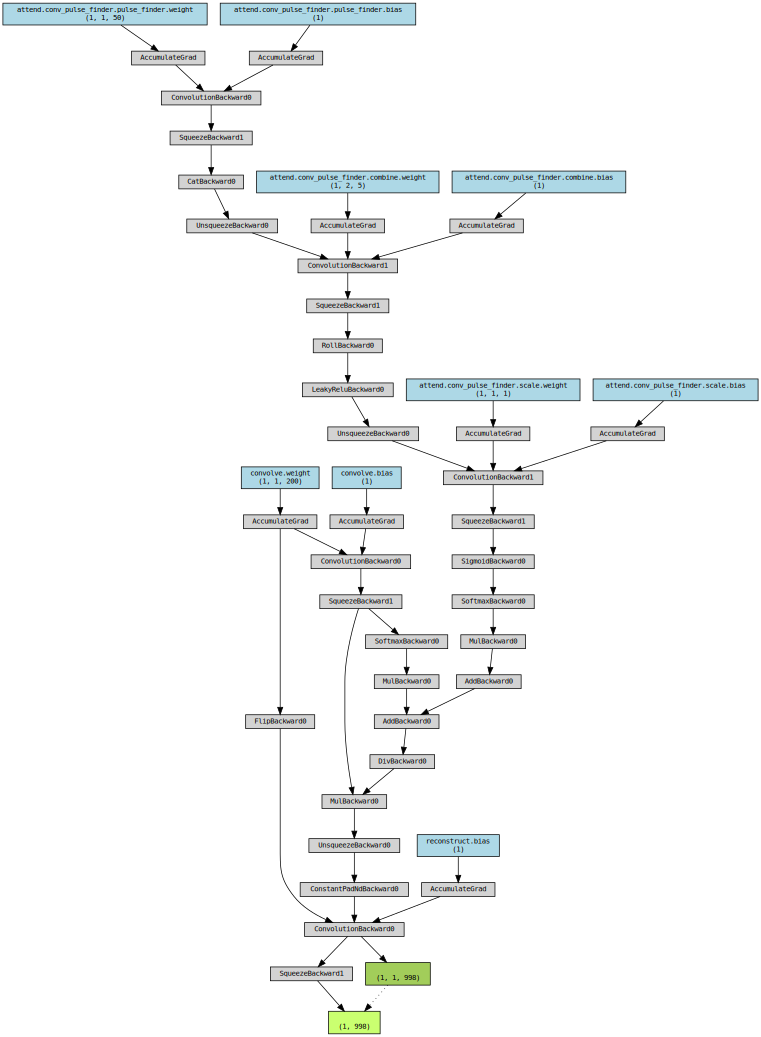

In [6]:
##    If a node represents a backward function, it is gray. Otherwise, the node
##   represents a tensor and is either blue, orange, or green:
##    - Blue: reachable leaf tensors that requires grad (tensors whose `.grad`
##        fields will be populated during `.backward()`)
##    - Orange: saved tensors of custom autograd functions as well as those
##        saved by built-in backward nodes
##    - Green: tensor passed in as outputs
##    - Dark green: if any output is a view, we represent its base tensor with
##        a dark green node.
make_dot(model(ds[0][0].to(device)), params=dict(list(model.named_parameters())))

## Train our model

In [7]:
params = split_parameters(model, ['attend'])
[[tuple(t.shape) for t in p["params"]] for p in params]

[[(1, 1, 50), (1,), (1, 2, 5), (1,), (1, 1, 1), (1,)],
 [(1, 1, 200), (1,), (1,)]]

In [16]:
lr_schedules = [lambda x: 0.99, lambda x: 0.95**x]
tester = train_parallel_pulse_finder(train_loader, model, param_groups=params,
                                     lr_schedules=lr_schedules, device=device,
                                     epochs=30,
                                     start_incrementing = 9,
                                     epochs_per_increment = 10,
                                     change_per_increment = 0.1,
)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

## Inspect what we've learnt

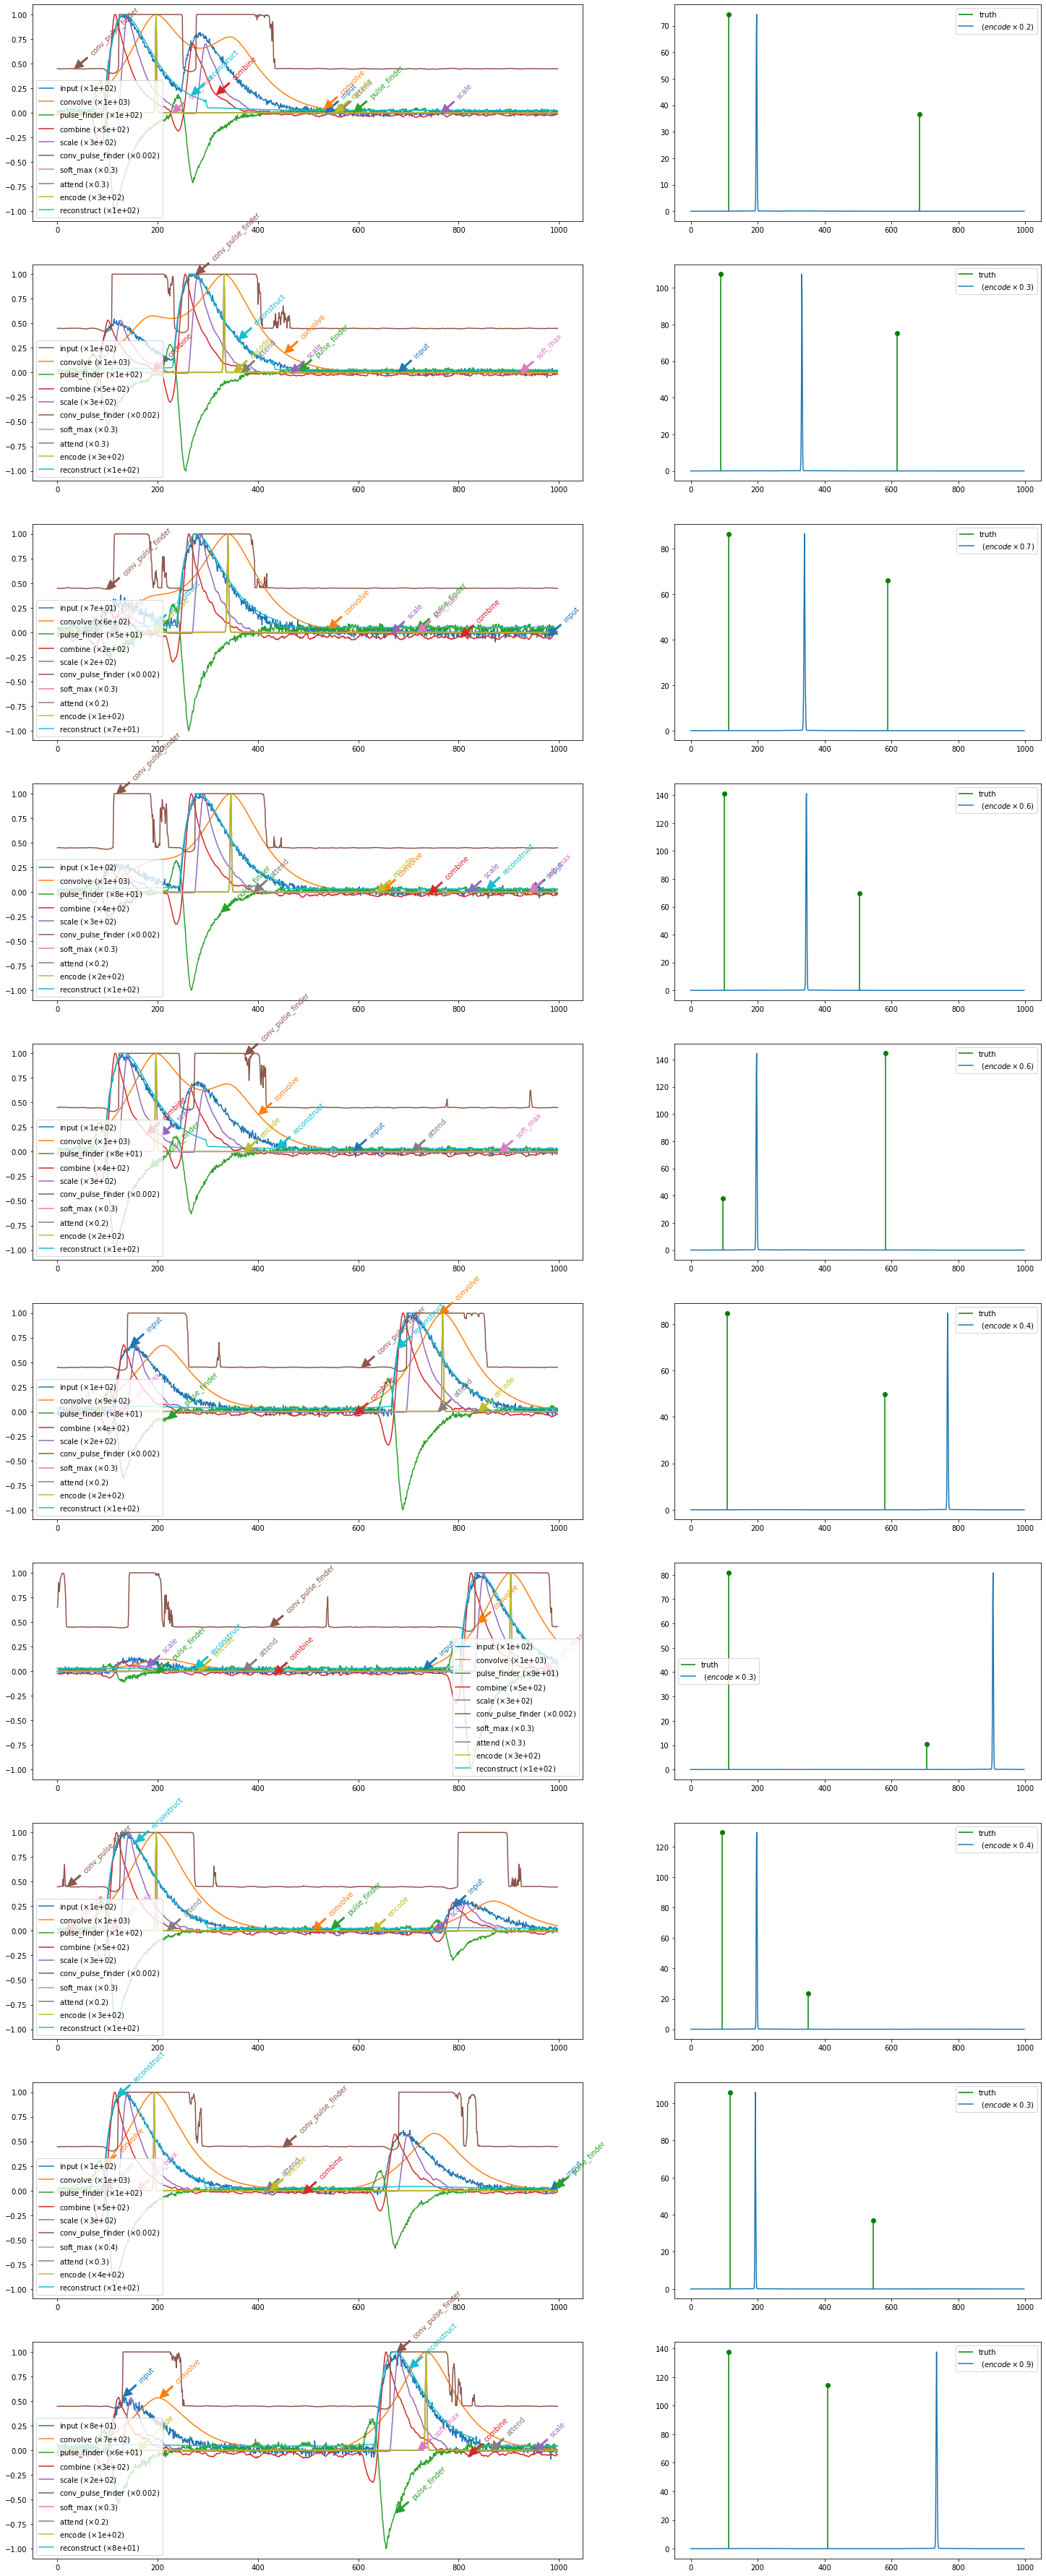

In [17]:
activations = InspectActivations(device)
activations.register(model, "attend", "encode", "convolve", "reconstruct")
activations.register(model.attend, "conv_pulse_finder", "soft_max")
activations.register(model.attend.conv_pulse_finder, "pulse_finder", "combine", "scale")

close_time = np.random.choice(np.where(truth[1][:, 1] < 250)[0], 5)
far_time = np.random.choice(np.where(truth[1][:, 1] > 500)[0], 5)
choices = np.concatenate((close_time, far_time))
activations.inspect(model, ds, true_amp=truth[0], true_time=truth[1], indices=choices, compare_truth="encode")

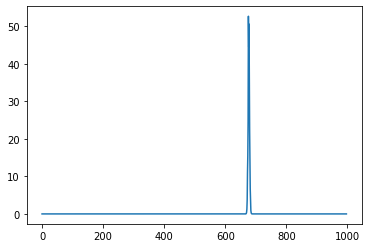

In [10]:
plt.plot(activations["encode"][0])

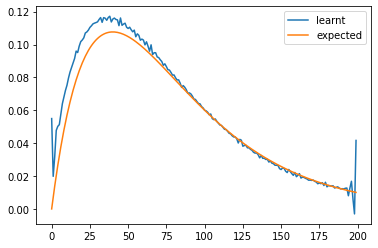

In [11]:
learnt = model.get_parameter("convolve.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt, label="learnt")
expected = wps.simple(np.arange(200), 40)
expected = expected / expected[100]* learnt[100]
plt.plot(expected, label="expected")
plt.legend()

-1.0081055

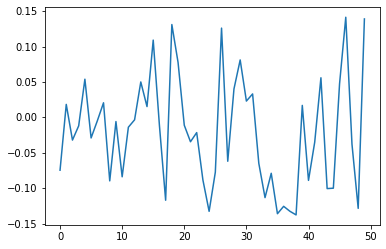

In [12]:
learnt = model.get_parameter("attend.conv_pulse_finder.pulse_finder.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)
learnt.sum()

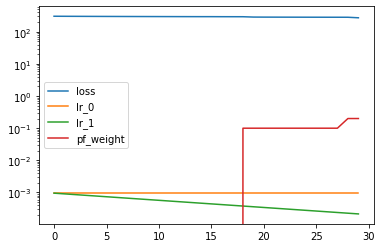

In [19]:
for name in ["loss", "lr_0", "lr_1", "pf_weight"]:
    plt.plot(tester.train[name], label=name);
plt.yscale("log")
plt.legend()

In [14]:
for name, param in model.named_parameters():
  print(f"{name} = {param}")
  print()

convolve.weight = Parameter containing:
tensor([[[ 0.0550,  0.0198,  0.0319,  0.0478,  0.0502,  0.0513,  0.0577,
           0.0640,  0.0680,  0.0720,  0.0752,  0.0796,  0.0832,  0.0859,
           0.0885,  0.0915,  0.0960,  0.0951,  0.0990,  0.1017,  0.1027,
           0.1040,  0.1070,  0.1076,  0.1088,  0.1104,  0.1114,  0.1126,
           0.1130,  0.1133,  0.1138,  0.1152,  0.1164,  0.1135,  0.1163,
           0.1160,  0.1147,  0.1164,  0.1172,  0.1137,  0.1155,  0.1161,
           0.1152,  0.1150,  0.1115,  0.1161,  0.1117,  0.1124,  0.1130,
           0.1105,  0.1098,  0.1105,  0.1090,  0.1077,  0.1087,  0.1047,
           0.1065,  0.1056,  0.1026,  0.1033,  0.1027,  0.0998,  0.1016,
           0.0990,  0.0959,  0.0998,  0.0939,  0.0950,  0.0950,  0.0924,
           0.0920,  0.0907,  0.0897,  0.0873,  0.0883,  0.0866,  0.0847,
           0.0845,  0.0830,  0.0814,  0.0815,  0.0797,  0.0784,  0.0785,
           0.0766,  0.0739,  0.0750,  0.0740,  0.0725,  0.0703,  0.0706,
           

In [15]:
model.attend.module_weights

{'conv_pulse_finder': 0, 'soft_max': 1}